## _Building Graphs: True Edges_

In [1]:
import glob, os, sys, yaml

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pprint
import seaborn as sns
import trackml.dataset

In [4]:
import torch
from torch_geometric.data import Data
import itertools

In [5]:
# append parent dir
sys.path.append('..')

# local imports
from src import Compose_Event, Draw_Compose_Event

### _(+) - Input Data_

In [6]:
# input data
input_dir = '../train_all'

In [7]:
# Find All Input Data Files (hits.csv, cells.csv, particles.csv, truth.csv)
all_files = os.listdir(input_dir)

# Extract File Prefixes (use e.g. xxx-hits.csv)
suffix = '-hits.csv'
file_prefixes = sorted(os.path.join(input_dir, f.replace(suffix, ''))
                       for f in all_files if f.endswith(suffix))

In [8]:
# file_prefixes[:10]

In [9]:
event_id = 1
event_prefix = file_prefixes[event_id]

In [10]:
# load an event
hits, tubes, particles, truth = trackml.dataset.load_event(event_prefix)

# memory usage
mem_bytes = (hits.memory_usage(index=True).sum() 
             + tubes.memory_usage(index=True).sum() 
             + particles.memory_usage(index=True).sum() 
             + truth.memory_usage(index=True).sum())

print('{} memory usage {:.2f} MB'.format(os.path.basename(event_prefix), mem_bytes / 2**20))

event0000000001 memory usage 0.03 MB


In [11]:
hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id
0,1,-7.87217,14.645000,35.0,9,0,7
1,2,-8.74686,15.150000,35.0,9,1,112
2,3,-8.74686,16.160000,35.0,9,2,222
3,4,-9.62154,16.665001,35.0,9,3,339
4,5,-9.62154,17.674999,35.0,9,4,461


In [12]:
tubes.head()

,hit_id,isochrone,depcharge,energyloss,volume_id,layer_id,module_id,skewed,sector_id
0,1,0.312154,8106480.0,8.10648,9,0,7,0,0
1,2,0.243986,4438520.0,4.43852,9,1,112,0,0
2,3,0.227273,12218100.0,12.21810,9,2,222,0,0
3,4,0.326345,4719830.0,4.71983,9,3,339,0,0
4,5,0.112023,12483800.0,12.48380,9,4,461,0,0


In [13]:
particles.head()

,particle_id,vx,vy,vz,px,py,pz,q,nhits,pdgcode,start_time
0,1,0.0,0.0,0.0,-0.467824,0.843642,-0.308224,1,26,13,0
1,2,0.0,0.0,0.0,-0.295066,0.393566,-0.364931,1,25,13,0
2,3,0.0,0.0,0.0,-0.266403,0.004486,0.150829,1,27,13,0
3,4,0.0,0.0,0.0,0.004641,0.066527,0.119620,1,40,13,0
4,5,0.0,0.0,0.0,0.193790,0.088343,0.188068,1,23,13,0


In [14]:
truth.head()

,hit_id,tx,ty,tz,tpx,tpy,tpz,weight,particle_id
0,1,-8.14818,14.503100,-12.1190,-0.304760,0.592697,-0.481614,1.0,10
1,2,-8.53445,15.258200,-12.7318,-0.302497,0.593937,-0.481471,1.0,10
2,3,-8.94150,16.061899,-13.3825,-0.299945,0.595248,-0.481365,1.0,10
3,4,-9.31965,16.815701,-13.9915,-0.297617,0.596324,-0.481449,1.0,10
4,5,-9.72147,17.625601,-14.6446,-0.295214,0.597517,-0.481419,1.0,10


### _(+) - Build Event_

- functions from _event_utils.py_

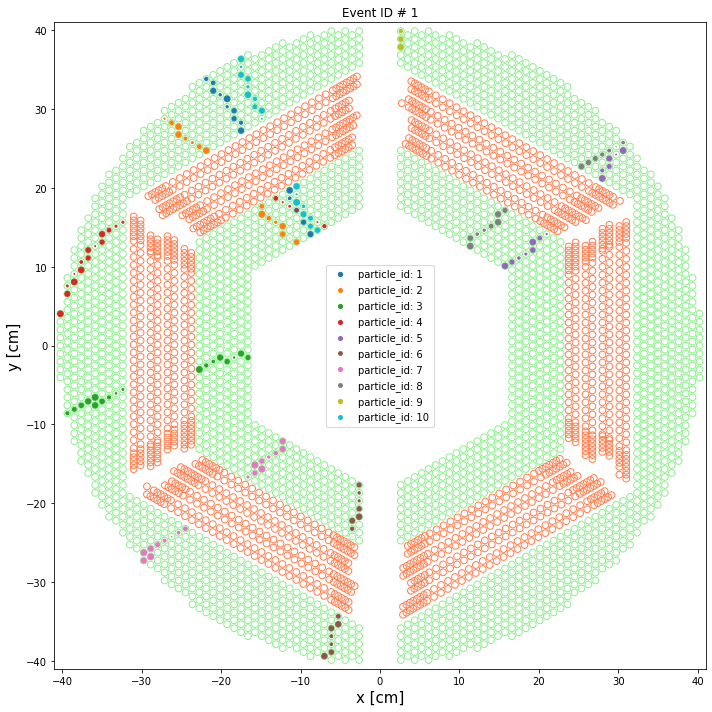

In [15]:
event = Compose_Event(event_prefix,skewed=False)
Draw_Compose_Event(event,figsize=(10,10));

## _Build Graphs_

### _(A) - True Edges (Layerwise)_

**True Graph** is the ground truth for GNN. It is built from creating edges from _`hits`_ from the same particle but in adjacent layers. 

For this purpose one has _`true_edges, hits = get_layerwise_edges(event)`_ function in the _`event_util.py`_.

In [16]:
# true_edges, hits = get_layerwise_edges(event)

In [17]:
# EDA on get_layerwise_edges(event)
hits = event

In [18]:
hits = hits.assign(
        R=np.sqrt(
            (hits.x - hits.vx) ** 2 + (hits.y - hits.vy) ** 2 + (hits.z - hits.vz) ** 2
        )
    )

In [19]:
hits = hits.sort_values("R").reset_index(drop=True).reset_index(drop=False)

In [20]:
hits.loc[hits["particle_id"] == 0, "particle_id"] = np.nan

In [21]:
hit_list = (
        hits.groupby(["particle_id", "layer_id"], sort=False)["index"]
        .agg(lambda x: list(x))
        .groupby(level=0)
        .agg(lambda x: list(x))
    )

In [22]:
hit_list

particle_id
1.0     [[1], [8], [15], [25], [34], [42], [51], [60],...
2.0     [[4], [12], [21], [28], [37], [46], [56], [65]...
3.0     [[2], [9], [18], [27], [36], [45], [55], [64],...
4.0     [[3], [10], [16], [26], [33], [44], [54], [63]...
5.0     [[19], [30], [39], [49], [61], [67], [70], [72...
6.0     [[13], [22], [31], [40], [53], [58], [68], [71...
7.0     [[6], [14], [23], [32], [41], [47, 50], [59], ...
8.0     [[5], [11], [20], [29], [38], [48], [57], [66]...
9.0                                 [[122], [135], [149]]
10.0    [[0], [7], [17], [24], [35], [43], [52], [62],...
Name: index, dtype: object

In [23]:
# get first row of hit list
row = hit_list.values[0]
row

[[1],
 [8],
 [15],
 [25],
 [34],
 [42],
 [51],
 [60],
 [73],
 [77],
 [84],
 [89],
 [98],
 [108],
 [118],
 [130],
 [143],
 [154]]

In [24]:
# get elements of array from 0 to n-1 i.e. skipping the last element
row[0:-1]

[[1],
 [8],
 [15],
 [25],
 [34],
 [42],
 [51],
 [60],
 [73],
 [77],
 [84],
 [89],
 [98],
 [108],
 [118],
 [130],
 [143]]

In [25]:
# get elements of array from 1 to n i.e. skipping the first elemnet
row[1:]

[[8],
 [15],
 [25],
 [34],
 [42],
 [51],
 [60],
 [73],
 [77],
 [84],
 [89],
 [98],
 [108],
 [118],
 [130],
 [143],
 [154]]

In [26]:
true_edges = []
for row in hit_list.values:
    for i, j in zip(row[0:-1], row[1:]): # row is list: we take 0 to n-1 elements as row[0:-1], and 1 to n as row[1:]
        true_edges.extend(list(itertools.product(i, j))) # extend() will add an iterable (list, set, etc) to the end of true_edges list, append() add one element to end of list.

In [27]:
true_edges = np.array(true_edges).T

* Now we have `true_edges` and corresponding `hits` (changed due to R parameter.)

In [28]:
# lets see how to access true_edges, 2D ndarray
true_edges

array([[  1,   8,  15,  25,  34,  42,  51,  60,  73,  77,  84,  89,  98,
        108, 118, 130, 143,   4,  12,  21,  28,  37,  46,  56,  65,  76,
         81,  88,  99, 110, 117, 131,   2,   9,  18,  27,  36,  45,  55,
         64,  75,  80,  85,  93,  93, 103, 105, 116, 127, 138,   3,  10,
         16,  26,  33,  44,  54,  63, 100, 104, 112, 112, 113, 121, 124,
        124, 128, 128, 133, 133, 134, 134, 137, 137, 139, 139, 145, 145,
        148, 153,  19,  30,  39,  49,  61,  67,  70,  72,  92,  95, 107,
        114, 125, 142,  13,  22,  31,  40,  53,  58,  68,  71,  86,  96,
        102, 115, 126, 141,   6,  14,  23,  32,  41,  41,  47,  50,  59,
         69,  79,  87,  94, 106, 119, 132, 132, 140, 147,   5,  11,  20,
         29,  38,  48,  57,  66,  82,  91, 101, 111, 123, 136, 122, 135,
          0,   7,  17,  24,  35,  43,  52,  62,  74,  78,  83,  90,  97,
        109, 120, 129, 144],
       [  8,  15,  25,  34,  42,  51,  60,  73,  77,  84,  89,  98, 108,
        118, 130, 143,

In [29]:
true_edges[0].size

160

In [30]:
true_edges[1].size

160

### _(+) - Plotting True Edges_

- I have hit pairs in two arrays
- Extract each pair (w/ `hit_id`) to plot
- How to plot hit pairs for one track?

In [31]:
from src.drawing import detector_layout
from src.utils_math import polar_to_cartesian

In [32]:
# lets get unique pids with freq (~ hits).
sel_pids, sel_pids_fr = np.unique(hits.particle_id, return_counts=True)
print(sel_pids)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


In [33]:
# check size of true_edges
size = true_edges.shape[1]
print(size)

160


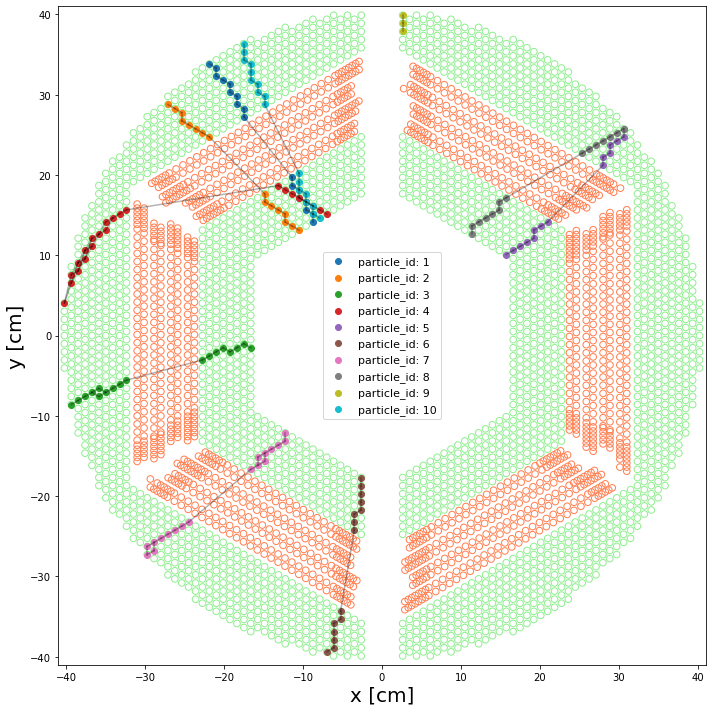

In [34]:
# Old: Plotting true_edges
plt.close('all')
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

p_ids = np.unique(event.particle_id.values)
det = pd.read_csv("../src/stt.csv")
skw = det.query('skewed==0')
nkw = det.query('skewed==1') # one look for +ve/-ve polarity

# detector layout
ax.scatter(skw.x.values, skw.y.values, s=44, facecolors='none', edgecolors='lightgreen')
ax.scatter(nkw.x.values, nkw.y.values, s=44, facecolors='none', edgecolors='coral')

# particle tracks
for pid in sel_pids:
    idx = hits.particle_id == pid
    ax.scatter(hits[idx].x.values, hits[idx].y.values, label='particle_id: %d' %pid)
    
# true edges
for iedge in range(true_edges.shape[1]):
    pt1 = hits.iloc[true_edges[0][iedge]]
    pt2 = hits.iloc[true_edges[1][iedge]]
    ax.plot([pt1.x, pt2.x], [pt1.y, pt2.y], color='k', alpha=0.3, lw=1.5)

# plotting params
ax.set_xlabel('x [cm]', fontsize=20)
ax.set_ylabel('y [cm]', fontsize=20)
# ax.set_title('Event ID # %d' % event_id)
ax.set_xlim(-41, 41)
ax.set_ylim(-41, 41)
ax.grid(False)
ax.legend(fontsize=11, loc='best')
fig.tight_layout()
fig.savefig("true_edges.pdf")

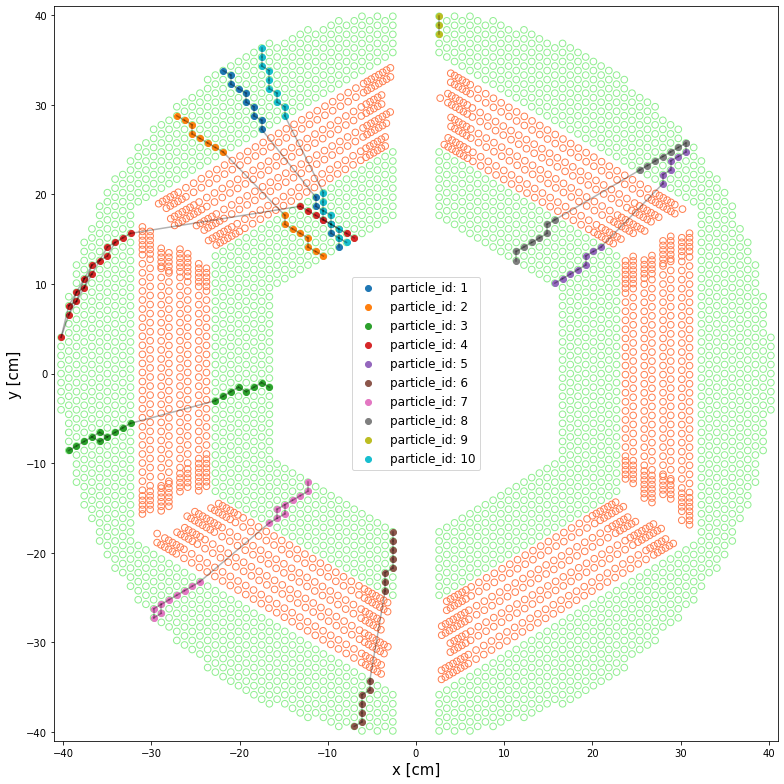

In [35]:
# New: Plotting true_edges
fig, ax = detector_layout(figsize=(11,11))

# particle tracks
for pid in sel_pids:
    idx = hits.particle_id == pid
    ax.scatter(hits[idx].x.values, hits[idx].y.values, label='particle_id: %d' %pid)
    
# true edges
for iedge in range(true_edges.shape[1]):
    pt1 = hits.iloc[true_edges[0][iedge]]
    pt2 = hits.iloc[true_edges[1][iedge]]
    ax.plot([pt1.x, pt2.x], [pt1.y, pt2.y], color='k', alpha=0.3, lw=1.5)

# axis params
ax.legend(fontsize=12, loc='best')
fig.tight_layout()
# fig.savefig("true_edges.pdf")